<a href="https://colab.research.google.com/github/kalleo1996/pysparkMLExample/blob/main/date_LinearRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pyspark

     |████████████████████████████████| 212.4MB 66kB/s 
     |████████████████████████████████| 204kB 17.1MB/s 
  Created wheel for pyspark: filename=pyspark-3.1.2-py2.py3-none-any.whl size=212880768 sha256=5a2313e661b469186a2b7650843dd03af68365afb2378037845cadeeab13301c
  Stored in directory: /root/.cache/pip/wheels/40/1b/2c/30f43be2627857ab80062bef1527c0128f7b4070b6b2d02139
Successfully built pyspark


In [2]:
from pyspark.sql import SparkSession

In [3]:
spark = SparkSession \
    .builder \
    .config("spark.driver.memory", "15g") \
    .appName("Exploratory Analysis") \
    .getOrCreate()

In [4]:
import numpy as np

import pandas as pd
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [5]:
parking2017 = spark.read.format("csv").option("header", "true").option("inferSchema", "true").load('/content/gdrive/My Drive/Big Data/Parking_Violations_Issued_-_Fiscal_Year_2017.csv')
parking2016 = spark.read.format("csv").option("header", "true").option("inferSchema", "true").load('/content/gdrive/My Drive/Big Data/Parking_Violations_Issued_-_Fiscal_Year_2016.csv')
parking2015 = spark.read.format("csv").option("header", "true").option("inferSchema", "true").load('/content/gdrive/My Drive/Big Data/Parking_Violations_Issued_-_Fiscal_Year_2015.csv')
parking2014 = spark.read.format("csv").option("header", "true").option("inferSchema", "true").load('/content/gdrive/My Drive/Big Data/Parking_Violations_Issued_-_Fiscal_Year_2014__August_2013___June_2014_.csv')

In [6]:
parking2017 = parking2017.dropDuplicates()
parking2016 = parking2016.dropDuplicates()
parking2015 = parking2015.dropDuplicates()
parking2014 = parking2014.dropDuplicates()

In [7]:
parking2017 = parking2017.toDF(*(c.replace(' ', '_') for c in parking2017.columns))
parking2016 = parking2016.toDF(*(c.replace(' ', '_') for c in parking2016.columns))
parking2015 = parking2015.toDF(*(c.replace(' ', '_') for c in parking2015.columns))
parking2014 = parking2014.toDF(*(c.replace(' ', '_') for c in parking2014.columns))

# Predictions

In [8]:
from pyspark.sql.functions import unix_timestamp, from_unixtime



In [9]:
parking2017.createOrReplaceTempView("parking2017")
parking2016.createOrReplaceTempView("parking2016")
parking2015.createOrReplaceTempView("parking2015")
parking2014.createOrReplaceTempView("parking2014")

In [10]:
parkingtable2017 = spark.sql("select Issue_Date,Violation_Location,Violation_Code from parking2017")
parkingtable2016 = spark.sql("select Issue_Date,Violation_Location,Violation_Code from parking2016")
parkingtable2015 = spark.sql("select Issue_Date,Violation_Location,Violation_Code from parking2015")
parkingtable2014 = spark.sql("select Issue_Date,Violation_Location,Violation_Code from parking2014")

In [11]:
from pyspark.sql.functions import unix_timestamp, from_unixtime

combinedparkingtable = parkingtable2017.union(parkingtable2016).union(parkingtable2015).union(parkingtable2014)
combinedparkingtable.show()

+----------+------------------+--------------+
|Issue_Date|Violation_Location|Violation_Code|
+----------+------------------+--------------+
|02/22/2017|                19|            18|
|01/27/2017|               110|            74|
|07/23/2016|                71|            20|
|06/23/2017|                30|            21|
|06/15/2017|              null|            36|
|02/16/2017|              null|            36|
|10/28/2016|                72|            21|
|05/30/2017|                90|            21|
|08/20/2016|                47|            16|
|11/11/2016|                 9|            40|
|02/16/2017|                40|            21|
|12/04/2016|                32|            71|
|03/09/2017|              null|             7|
|10/13/2016|              null|             5|
|04/10/2017|                24|            21|
|10/04/2016|                23|            38|
|05/08/2017|               110|            13|
|10/29/2016|               112|            37|
|03/15/2017| 

In [12]:
combinedparkingtable=combinedparkingtable.dropna()

In [13]:
combinedparkingtable.createOrReplaceTempView("combinedparkingtableView")

In [14]:
from pyspark.sql.functions import udf,desc
from datetime import datetime

In [15]:


from pyspark.sql.functions import date_format
from pyspark.sql.functions import to_date, date_format

from pyspark.sql.functions import *


NameError: ignored

In [ ]:
#data_2017_day.show(100)

for 2014 to 2016 first

In [18]:
data_2014 = spark.sql("select year(from_unixtime(unix_timestamp(Issue_Date, 'MM/dd/yyy'))) as year,month(from_unixtime(unix_timestamp(Issue_Date, 'MM/dd/yyy'))) as month,day(from_unixtime(unix_timestamp(Issue_Date, 'MM/dd/yyy'))) as day,Violation_Location, Violation_Code , count(*) as frequency from combinedparkingtableView  Group by year,month,day,Violation_Location, Violation_Code order by year,month,day,Violation_Location,Violation_Code ")
data_2014.createOrReplaceTempView("data_2014")
data_2014 = spark.sql("select year,month,day,Violation_Location,Violation_Code,frequency from data_2014 where year >= 2014 ")



In [19]:
data_2014.dtypes

[('year', 'int'),
 ('month', 'int'),
 ('day', 'int'),
 ('Violation_Location', 'int'),
 ('Violation_Code', 'int'),
 ('frequency', 'bigint')]

In [20]:
data_2014_day = spark.sql("select year(from_unixtime(unix_timestamp(Issue_Date, 'MM/dd/yyy'))) as year,month(from_unixtime(unix_timestamp(Issue_Date, 'MM/dd/yyy'))) as month,day(from_unixtime(unix_timestamp(Issue_Date, 'MM/dd/yyy'))) as day,Violation_Location,count(*) as totalViolation from combinedparkingtableView  Group by year,month,day,Violation_Location order by year,month,day,Violation_Location ")
data_2014_day.createOrReplaceTempView("data_2014_day")
data_2014_day= spark.sql("select year,month,day,Violation_Location,totalViolation from data_2014_day where year >= 2014 ")


In [21]:
data_2014_day.dtypes

[('year', 'int'),
 ('month', 'int'),
 ('day', 'int'),
 ('Violation_Location', 'int'),
 ('totalViolation', 'bigint')]

In [22]:
import pyspark.sql.functions as F
from pyspark.sql.functions import round, col
df_2014 = data_2014.join(data_2014_day, (data_2014.Violation_Location == data_2014_day.Violation_Location) & (data_2014.year == data_2014_day.year)& (data_2014.month == data_2014_day.month) & (data_2014_day.day == data_2014_day.day))\
    .withColumn("violation_probability", round(F.col("frequency") / F.col("totalViolation"), 5))\
    .drop(data_2014_day.totalViolation).drop(data_2014.frequency).drop(data_2014_day.Violation_Location).drop(data_2014_day.month).drop(data_2014_day.day).drop(data_2014_day.year)


#df_2015.show()

In [23]:
#dataframe concatenation
from functools import reduce  # For Python 3.x
from pyspark.sql import DataFrame

#def unionAll(*dfs):
    #return reduce(DataFrame.unionAll, dfs)

#full_df = unionAll(df_2014,df_2015, df_2016,df)
#train_df.show(10)

In [24]:
full_df = df_2014

In [25]:
from pyspark.sql.functions import countDistinct
df2=full_df.select(countDistinct("Violation_Location"))
df2.show()

+----------------------------------+
|count(DISTINCT Violation_Location)|
+----------------------------------+
|                               661|
+----------------------------------+



In [26]:
#from pyspark.ml.feature import StringIndexer
#qualification_indexer = StringIndexer(inputCol="day", outputCol="day_chng")
#Fits a model to the input dataset with optional parameters.
#df_buck = qualification_indexer.fit(full_df).transform(full_df)
#df_buck.show()

In [27]:
from pyspark.ml.feature import OneHotEncoder

#for training data
#

day_encoded = OneHotEncoder(inputCol="day", outputCol="day_one")
df_buck = day_encoded.fit(full_df).transform(full_df)







#df_buck_train.show(10)

In [28]:
location_encoded = OneHotEncoder(inputCol="Violation_Location", outputCol="Violation_Location_one")
df_buck1 = location_encoded.fit(df_buck).transform(df_buck)

In [29]:
code_encoded = OneHotEncoder(inputCol="Violation_Code", outputCol="Violation_Code_one")
df_buck2 = code_encoded.fit(df_buck1).transform(df_buck1)


In [30]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

#for training data
#assembler = VectorAssembler(inputCols=["day_one","month_one","Violation_Location_one","week_one","Violation_Code_one"], outputCol="features")
# Assemble all the features with VectorAssembler
required_features = ["year","month","day_one","Violation_Location_one","Violation_Code_one"]

from pyspark.ml.feature import VectorAssembler

numericCols = [] #['prob']
assemblerInputs = [c  for c in required_features] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol='features')

transformed_data = assembler.transform(df_buck2)
#transformed_data.show(5)

In [31]:
(training_data, test_data) = transformed_data.randomSplit([0.8,0.2], seed =2020)

In [32]:
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(featuresCol = 'features', labelCol='violation_probability')
lr_model = lr.fit(training_data)
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

Coefficients: [0.009198163663188954,0.0007132379265789565,0.0,0.00044106002476779015,-0.0013641567249116256,-0.0012469658649644725,0.0009345608173774357,0.0007468333335242719,-0.0008519526414548507,-0.0012749430529274532,-0.0015730254403098834,-0.001982919996667503,-0.002291051157028357,-0.0012971314057212075,-0.0019044679049337058,-0.0017944670187404418,-0.0010456938696567642,-0.001542613875581202,-0.0013093295515321727,-0.0009944856412085817,0.00021236333221708853,-0.0007951623239941529,-0.0014767461679889686,-0.0022948276754486117,-0.0023311637193822684,-0.0015468234287413234,-0.0016111699437178387,0.0007219273619567959,0.0015501216591279185,-0.0008375101339742665,-0.0017416326826572215,-0.0003846349227402771,-0.0012548761100173392,0.0,-0.9240278688905341,-0.34349396504173335,-0.13726919982468336,-0.1990149213700992,-0.9242521541788046,-0.922491443547461,-0.9193839605864045,-0.20641451893649526,-0.9223770383626877,-0.9261154129642374,-0.18529229292576546,-0.2388806643714731,-0.92657

In [34]:
model_path = "/content/gdrive/My Drive/Big Data/" + "modeldatekalpani"
lr_model.save(model_path)

In [35]:
from pyspark.ml.regression import LinearRegressionModel
model2 = LinearRegressionModel.load(model_path)

In [36]:
model2_predict = model2.transform(test_data.limit(10))

In [38]:
model2_predict.select("prediction","violation_probability","features").show(10,False)

+---------------------+---------------------+------------------------------------------------+
|prediction           |violation_probability|features                                        |
+---------------------+---------------------+------------------------------------------------+
|0.029765229807242832 |0.07258              |(1126,[0,1,3,104,1097],[2014.0,1.0,1.0,1.0,1.0])|
|0.011169659261572207 |0.01613              |(1126,[0,1,3,104,1101],[2014.0,1.0,1.0,1.0,1.0])|
|0.0187673862443134   |0.125                |(1126,[0,1,7,155,1088],[2014.0,1.0,1.0,1.0,1.0])|
|0.034323815498193966 |0.25                 |(1126,[0,1,7,155,1105],[2014.0,1.0,1.0,1.0,1.0])|
|0.03228899765318971  |0.25                 |(1126,[0,1,7,155,1125],[2014.0,1.0,1.0,1.0,1.0])|
|0.03707966588781275  |0.00152              |(1126,[0,1,8,103,1058],[2014.0,1.0,1.0,1.0,1.0])|
|0.689909834399586    |1.0                  |(1126,[0,1,8,45,1072],[2014.0,1.0,1.0,1.0,1.0]) |
|0.0699534583914243   |0.03805              |(1126

In [39]:

print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

Coefficients: [0.009198163663188954,0.0007132379265789565,0.0,0.00044106002476779015,-0.0013641567249116256,-0.0012469658649644725,0.0009345608173774357,0.0007468333335242719,-0.0008519526414548507,-0.0012749430529274532,-0.0015730254403098834,-0.001982919996667503,-0.002291051157028357,-0.0012971314057212075,-0.0019044679049337058,-0.0017944670187404418,-0.0010456938696567642,-0.001542613875581202,-0.0013093295515321727,-0.0009944856412085817,0.00021236333221708853,-0.0007951623239941529,-0.0014767461679889686,-0.0022948276754486117,-0.0023311637193822684,-0.0015468234287413234,-0.0016111699437178387,0.0007219273619567959,0.0015501216591279185,-0.0008375101339742665,-0.0017416326826572215,-0.0003846349227402771,-0.0012548761100173392,0.0,-0.9240278688905341,-0.34349396504173335,-0.13726919982468336,-0.1990149213700992,-0.9242521541788046,-0.922491443547461,-0.9193839605864045,-0.20641451893649526,-0.9223770383626877,-0.9261154129642374,-0.18529229292576546,-0.2388806643714731,-0.92657

In [40]:
lr_predictions = lr_model.transform(test_data)
lr_predictions.select("prediction","violation_probability","features").show(100)

+--------------------+---------------------+--------------------+
|          prediction|violation_probability|            features|
+--------------------+---------------------+--------------------+
|0.029765229807242832|              0.07258|(1126,[0,1,3,104,...|
|0.011169659261572207|              0.01613|(1126,[0,1,3,104,...|
|  0.0187673862443134|                0.125|(1126,[0,1,7,155,...|
|0.034323815498193966|                 0.25|(1126,[0,1,7,155,...|
| 0.03228899765318971|                 0.25|(1126,[0,1,7,155,...|
| 0.03707966588781275|              0.00152|(1126,[0,1,8,103,...|
|   0.689909834399586|                  1.0|(1126,[0,1,8,45,1...|
|  0.0699534583914243|              0.03805|(1126,[0,1,8,103,...|
|-0.00603728331087...|              0.00319|(1126,[0,1,10,77,...|
|-0.00521023348921...|              0.01278|(1126,[0,1,10,77,...|
|-0.00194391271242...|              0.00319|(1126,[0,1,10,77,...|
| 0.02053084266064431|              0.00319|(1126,[0,1,10,77,...|
|  0.21353

In [41]:
dataForGrapgh = lr_predictions.select("prediction","violation_probability","features")

In [42]:
dataG =dataForGrapgh.toPandas()

In [43]:
# Necessary imports: 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics
accuracy = metrics.r2_score(dataG['violation_probability'], dataG['prediction'])
print("Cross-Predicted Accuracy:", accuracy)

Cross-Predicted Accuracy: 0.5465748870288807


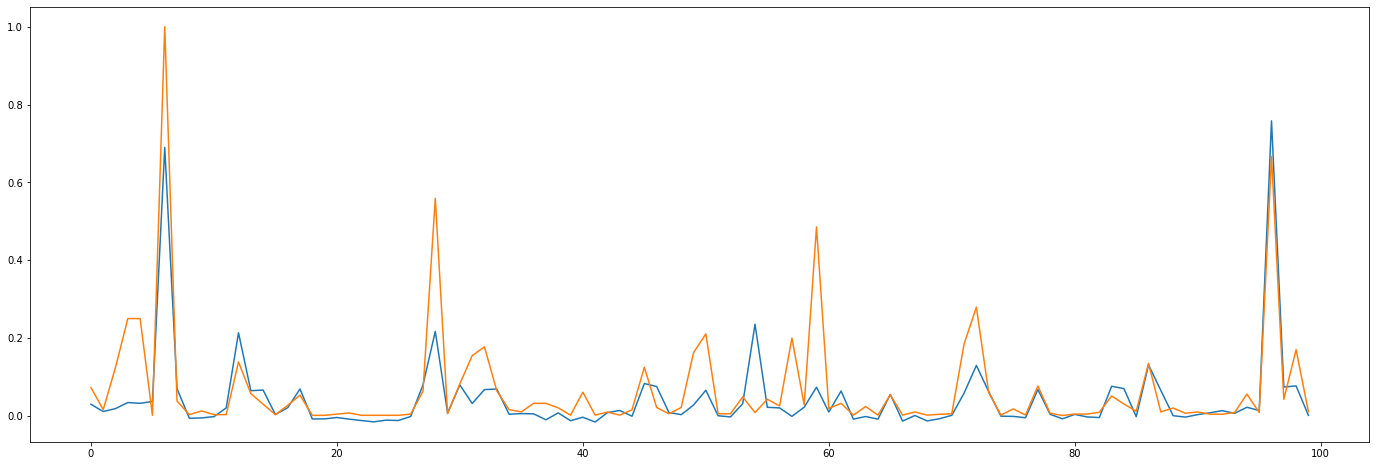

In [44]:
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (24, 8)
plt.plot(dataG['prediction'][:100], label = "Pred")  # Load the 500 data points from prediction with label name 'Pred'
plt.plot(dataG['violation_probability'][:100], label = "Actual")